## Data Collection

Main data collection is processed by running ['update.py'](https://github.com/cjunwon/Youtube-Data-Analysis/blob/main/update.py) on a Flask ['server.py'](https://github.com/cjunwon/Youtube-Data-Analysis/blob/main/server.py) scheduled through ngrok and Invictify.

This collection pipeline automatically updates the AWS MySQL RDS database with up-to-date channel statistics depending on the configured Invictify schedule.

In [71]:
from MySQL_DB_connect_functions import *
from MySQL_DB_update_functions import *
from youtube_api_functions import *

In [72]:
channel_id_list = ['UCIRYBXDze5krPDzAEOxFGVA'] #TheGuardian
channel_id_list = ['UCqnbDFdCpuN8CMEg0VuEBqA'] #NYTimes

In [73]:
# using youtube_api_functions.py:
youtube_obj = build_yt_API_object() # builds Youtube API object

In [74]:
video_df = create_video_df(youtube_obj, channel_id_list, 150) # store API data into pandas df
processed_video_df = clean_video_df(video_df) # run df through cleaning function

In [75]:
processed_video_df.head()

,video_id,channelTitle,title,description,publishedAt,viewCount,likeCount,favoriteCount,commentCount,caption,publishDayName,durationSecs,tagCount
0,FJvnn0qRWb4,The New York Times,Watch Warriors in Training in ‘The Woman King’...,The intensity of the action epic “The Woman Ki...,2022-09-16,5654.0,231.0,0.0,0.0,1,Friday,119.0,11
1,O5d1Cclk5QA,The New York Times,"I Sold the French Laundry. Then It Became ""The...","When my father died, he held disappointment in...",2022-09-13,54015.0,2372.0,0.0,218.0,1,Tuesday,1233.0,21
2,ccVH_1g-kCY,The New York Times,OB-GYNs Confront Legal Impact of Abortion Bans...,As anti-abortion laws take effect across the U...,2022-09-12,11695.0,607.0,0.0,318.0,1,Monday,379.0,33
3,0bw7rJ2eZaA,The New York Times,The Legacy of Elizabeth II: The Media Queen,"Queen Elizabeth II, the world’s longest-servin...",2022-09-08,56300.0,2052.0,0.0,377.0,1,Thursday,486.0,19
4,m5aWtcx02ZI,The New York Times,Jonathan Pie: Welcome to Britain. Everything i...,So Liz Truss will be Britain’s next prime mini...,2022-09-06,885528.0,44682.0,0.0,4990.0,1,Tuesday,401.0,15


In [76]:
selected_df = processed_video_df.query('viewCount > 5000 & commentCount > 500')

In [77]:
len(selected_df)

68

In [78]:
selected_df

,video_id,channelTitle,title,description,publishedAt,viewCount,likeCount,favoriteCount,commentCount,caption,publishDayName,durationSecs,tagCount
4,m5aWtcx02ZI,The New York Times,Jonathan Pie: Welcome to Britain. Everything i...,So Liz Truss will be Britain’s next prime mini...,2022-09-06,885528.0,44682.0,0.0,4990.0,1,Tuesday,401.0,15
9,eMGqvUZjkH8,The New York Times,Kill Your Lawn | NYT Opinion,"Seen from above, it’s not the undulating rows ...",2022-08-09,86238.0,3617.0,0.0,582.0,1,Tuesday,321.0,20
14,RilwnjDwTOc,The New York Times,We Debunk the Latest Corporate Climate Lie | N...,"Finally, corporations are jumping into action ...",2022-07-14,282818.0,13268.0,0.0,1586.0,1,Thursday,288.0,17
17,tjIgYs81mB8,The New York Times,How I Had an Abortion at Home in Texas | NYT O...,This is the true story of a 27-year-old Texas ...,2022-06-29,284347.0,8819.0,0.0,7767.0,1,Wednesday,475.0,16
20,Oo_FM3mjBCY,The New York Times,How China’s Surveillance Is Growing More Invas...,"A New York Times analysis of over 100,000 gove...",2022-06-22,258147.0,9793.0,0.0,1543.0,1,Wednesday,867.0,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,NOJzyvOrh8I,The New York Times,"A Letter From Death Row: Gov. Abbott, Will You...","Quintin Jones, an inmate on death row in Texas...",2021-05-10,70103.0,1960.0,0.0,863.0,0,Monday,247.0,12
145,DlnfiULnmMY,The New York Times,Inside the Daily Life of a Live Streaming Star...,"Over the past year, as Covid-19 has severely l...",2021-04-29,2061443.0,47979.0,0.0,4139.0,0,Thursday,770.0,21
146,EBklyksgbco,The New York Times,What Does U.S. Health Care Look Like Abroad? |...,Byzantine health plans. Impoverishing deductib...,2021-04-28,978447.0,30908.0,0.0,9999.0,1,Wednesday,374.0,8
147,_PSBQvxVuoY,The New York Times,How ICE’s Mishandling of Covid-19 Fueled Outbr...,"To date, Immigration and Customs Enforcement h...",2021-04-26,52550.0,701.0,0.0,683.0,1,Monday,880.0,28


In [79]:
video_ids = list(selected_df['video_id'])

In [80]:
video_ids

['m5aWtcx02ZI',
 'eMGqvUZjkH8',
 'RilwnjDwTOc',
 'tjIgYs81mB8',
 'Oo_FM3mjBCY',
 '2D_Ogifqm2c',
 '-DfLbrUa5Ng',
 '9RnjVFZoHuc',
 'v1_ilS5zku8',
 'j4qwMGd2wmQ',
 'pCCTf17ZiIs',
 'Wr7BrKOX6bE',
 'ODU_QasrkcQ',
 'N04aLpZ0SJ8',
 'pCnlxfBgq4o',
 'ww8PjviNPfw',
 'gCldVMfFim8',
 'Ws0mMP7uM34',
 'gOmYi96cU1M',
 'n54Jyt_P0FY',
 'AoFdE0ssDSA',
 'H8zDt4VKkVY',
 'YAblAQENQhE',
 '8BtPV1gIaJs',
 'ifhD-ZGChr8',
 'C1kTEit6-qw',
 'gCS9Nlkq5ng',
 '7xml90IvQJ0',
 'm6xE7rieXU0',
 'GkSsC6aCFbU',
 'QS7kUqKeg_0',
 'kOcLyyVyb6o',
 '0ilKQRXySg8',
 'PrDyii0P4DU',
 'mX5ObMEVurM',
 'zyA68Gs1Mto',
 'hNDgcjVGHIw',
 'VpTW2AJE9MQ',
 '2axbxYbWLmk',
 'iXKZtAiOPQE',
 'nRFVR_JpxDc',
 'q0hqnMUi3NA',
 'w8l4iI40ues',
 'ZtecNyXxb9A',
 '8dCuSBJtZlk',
 'G6ZkONEx2Kw',
 'g8FdEvyyZhs',
 'YhyN0ve1PYI',
 'pd8P12BXebo',
 'LpYhU4kR7TU',
 'i9pwJF6n720',
 'NDW9zKqvPJI',
 '4P_L_088Diw',
 'TjxC-evzxdk',
 's6GxHgbvmaI',
 'vPFkcoTfr7g',
 '4fYpvhMgQ_4',
 'jWJVMoe7OY0',
 'rrYHge7tqsQ',
 '07WZH-RIe_U',
 'V83mytQX37A',
 '5e7QWV9LB_c',
 'ZuL_3d

In [81]:
all_comments_df = pd.DataFrame()
for video in video_ids:
    comment_data = get_video_comments(youtube_obj, video)
    all_comments_df = all_comments_df.append(comment_data, ignore_index=True)

In [82]:
all_comments_df.head()

,video_id,comment_id,comment,date
0,m5aWtcx02ZI,UgxufqRCtXh89VL-mfp4AaABAg,"Though we walk through the valley of death, so...",2022-09-15T23:18:04Z
1,m5aWtcx02ZI,UgwUecmtXM7o_sFXgo14AaABAg,"As a citizen of burgerland, I can confirm Brit...",2022-09-15T22:42:25Z
2,m5aWtcx02ZI,Ugydc96B5N4nXidOG0h4AaABAg,Really boring. Yet another 'I hate the British...,2022-09-15T22:17:28Z
3,m5aWtcx02ZI,UgzxQz_m_QuKjo82Jy94AaABAg,very surprised yall had him on.\nvery progress...,2022-09-15T21:45:34Z
4,m5aWtcx02ZI,UgykCYZTg5fHmL0FcGZ4AaABAg,The New York Times taking the opportunity to p...,2022-09-15T21:26:09Z


In [83]:
all_comments_df['comment'][3]

'very surprised yall had him on.\nvery progressive.'

## Comment Data Cleaning

In [84]:
def preprocess(comment):
    comment = comment.str.replace("\n", " ") # remove new lines 
    return comment

all_comments_df['comment'] = preprocess(all_comments_df['comment'])

In [85]:
all_comments_df

,video_id,comment_id,comment,date
0,m5aWtcx02ZI,UgxufqRCtXh89VL-mfp4AaABAg,"Though we walk through the valley of death, so...",2022-09-15T23:18:04Z
1,m5aWtcx02ZI,UgwUecmtXM7o_sFXgo14AaABAg,"As a citizen of burgerland, I can confirm Brit...",2022-09-15T22:42:25Z
2,m5aWtcx02ZI,Ugydc96B5N4nXidOG0h4AaABAg,Really boring. Yet another 'I hate the British...,2022-09-15T22:17:28Z
3,m5aWtcx02ZI,UgzxQz_m_QuKjo82Jy94AaABAg,very surprised yall had him on. very progressive.,2022-09-15T21:45:34Z
4,m5aWtcx02ZI,UgykCYZTg5fHmL0FcGZ4AaABAg,The New York Times taking the opportunity to p...,2022-09-15T21:26:09Z
...,...,...,...,...
6794,O-g4XGPlGZU,Ugz6NcYNCahq9SOIE9Z4AaABAg,"While the kid didn't deserve to die, he should...",2021-04-20T06:07:19Z
6795,O-g4XGPlGZU,UgxfHiY17I4ZvHz9Ltl4AaABAg,Maybe if you register your car and not have a ...,2021-04-20T06:05:00Z
6796,O-g4XGPlGZU,Ugz1oE-OHjtlzX6zkLN4AaABAg,Tell me how you look at the body cam seeing hi...,2021-04-20T06:02:22Z
6797,O-g4XGPlGZU,UgxdBZrhn_NWDP_xDuF4AaABAg,The racist people in these comments genuinely ...,2021-04-20T05:56:56Z


In [96]:
all_comments_df['comment'][3]

'very surprised yall had him on. very progressive.'

In [86]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [87]:
all_comments_df['vader_sentiment'] = all_comments_df.comment.apply(lambda x: sia.polarity_scores(x))
all_comments_df['vader_comp_sentiment'] = all_comments_df.vader_sentiment.apply(lambda x: x['compound'])

In [88]:
all_comments_df['vader_comp_sentiment'].mean()

-0.012761053096043577

In [89]:
video_comp_sentiments = pd.DataFrame(columns=['video_id', 'vid_title', 'avg_comp_sentiment', 'vid_viewcount'])
for video in video_ids:
    comment_data = get_video_comments(youtube_obj, video)
    comment_data['vader_sentiment'] = comment_data.comment.apply(lambda x: sia.polarity_scores(x))
    comment_data['vader_comp_sentiment'] = comment_data.vader_sentiment.apply(lambda x: x['compound'])
    comp_mean = comment_data['vader_comp_sentiment'].mean()

    vid_title = processed_video_df.loc[processed_video_df['video_id'] == video, 'title'].item()
    vid_viewcount = processed_video_df.loc[processed_video_df['video_id'] == video, 'viewCount'].item()
    vid_likecount = processed_video_df.loc[processed_video_df['video_id'] == video, 'likeCount'].item()

    dict = {'video_id': video,
            'vid_title': vid_title,
            'avg_comp_sentiment': comp_mean,
            'vid_viewcount': vid_viewcount,
            'vid_likecount': vid_likecount
            }

    video_comp_sentiments = video_comp_sentiments.append(dict, ignore_index=True)
    

In [90]:
video_comp_sentiments

,video_id,vid_title,avg_comp_sentiment,vid_viewcount,vid_likecount
0,m5aWtcx02ZI,Jonathan Pie: Welcome to Britain. Everything i...,0.040505,885528.0,44682.0
1,eMGqvUZjkH8,Kill Your Lawn | NYT Opinion,0.118600,86238.0,3617.0
2,RilwnjDwTOc,We Debunk the Latest Corporate Climate Lie | N...,-0.014841,282818.0,13268.0
3,tjIgYs81mB8,How I Had an Abortion at Home in Texas | NYT O...,-0.189609,284347.0,8819.0
4,Oo_FM3mjBCY,How China’s Surveillance Is Growing More Invas...,0.028863,258147.0,9793.0
...,...,...,...,...,...
63,NOJzyvOrh8I,"A Letter From Death Row: Gov. Abbott, Will You...",-0.213699,70103.0,1960.0
64,DlnfiULnmMY,Inside the Daily Life of a Live Streaming Star...,0.054067,2061443.0,47979.0
65,EBklyksgbco,What Does U.S. Health Care Look Like Abroad? |...,0.040319,978447.0,30908.0
66,_PSBQvxVuoY,How ICE’s Mishandling of Covid-19 Fueled Outbr...,-0.036028,52550.0,701.0


In [91]:
import plotly.io as pio
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'vscode'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [92]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [93]:
fig = make_subplots(specs=[[{'secondary_y': True}]])

fig.add_trace(
        go.Scatter(
        x=video_comp_sentiments['avg_comp_sentiment'],
        y=video_comp_sentiments['vid_viewcount'],
        mode='markers',
        marker_color='Blue',
        text=video_comp_sentiments['vid_title'],
        hovertemplate='<b>%{text}</b> <br>Sentiment Value: %{x} <br>View Count: %{y}'),
        secondary_y=False
)

fig.add_trace(go.Scatter(
    x=video_comp_sentiments['avg_comp_sentiment'],
    y=video_comp_sentiments['vid_likecount'],
    mode='markers',
    marker_color='Red',
    text=video_comp_sentiments['vid_title'],
    hovertemplate='<b>%{text}</b> <br>Sentiment Value: %{x} <br>Like Count: %{y}'),
    secondary_y=True
)

fig.show(renderer='vscode')

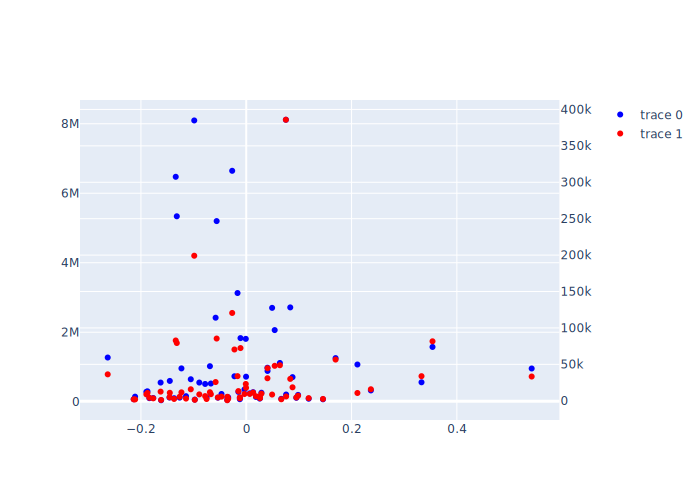

In [94]:
fig = make_subplots(specs=[[{'secondary_y': True}]])

fig.add_trace(
        go.Scatter(
        x=video_comp_sentiments['avg_comp_sentiment'],
        y=video_comp_sentiments['vid_viewcount'],
        mode='markers',
        marker_color='Blue',
        text=video_comp_sentiments['vid_title'],
        hovertemplate='<b>%{text}</b> <br>Sentiment Value: %{x} <br>View Count: %{y}'),
        secondary_y=False
)

fig.add_trace(go.Scatter(
    x=video_comp_sentiments['avg_comp_sentiment'],
    y=video_comp_sentiments['vid_likecount'],
    mode='markers',
    marker_color='Red',
    text=video_comp_sentiments['vid_title'],
    hovertemplate='<b>%{text}</b> <br>Sentiment Value: %{x} <br>Like Count: %{y}'),
    secondary_y=True
)

fig.show(renderer='svg')

In [95]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
 
# plot a scatter chart by specifying the x and y values
# Use add_trace function to specify secondary_y axes.
fig.add_trace(
    go.Scatter(x=[10, 20, 30], y=[400, 500, 600], name="yaxis values"),
    secondary_y=False)
 
# Use add_trace function and specify secondary_y axes = True.
fig.add_trace(
    go.Scatter(x=[20, 30, 40], y=[40, 50, 60], name="yaxis2 values"),
    secondary_y=True,)
 
# Adding title text to the figure
fig.update_layout(
    title_text="Multiple Y Axis in Plotly"
)
 
# Naming x-axis
fig.update_xaxes(title_text="X - axis")
 
# Naming y-axes
fig.update_yaxes(title_text="<b>Main</b> Y - axis ", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> Y - axis ", secondary_y=True)